# Analisi della Banda Ultra Larga (BUL)

In [18]:
import requests
import time
import pandas as pd
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import re

## Fonti e metodi
i dati sono reperibili a [questo](https://misurainternet.it/valori_statistici) gestito da AGCOM, l'autorità garante delle telecomunicazioni che mette disposizione i dati forniti dalle analisi con tool appositi dei vari operatori presenti nel territorio italiano. Sfortunamente i dati sono forniti solo tramite una pagina HTML, si è reso fare webscraping dal sito.

Per massimizzare la quantità di voci fornite, abbiamo analizzato come vengono effettuate le richieste alla pagina e definito i valori per acquisire i dati, ovvero:

- __csrfmiddlewaretoken__: Token di sicurezza, per convalidare l'accesso, recuperato dagli headers;
- __regione__: regione di ricerca, definita mendiate un parametro numerico di tipo NN (es. 01);
- __anno__: anno di ricerca;
- __page__: molte tabelle sono divise in più pagine.
- __periodo__: le misure possono essere divisi in due semestri

In [2]:
anni = ["2014", "2015", "2016", "2017", "2018", "2019","2020","2021", "2022"]
semestri = ["semestre_i", "semestre_ii"]
regioni ={
    1: "Piemonte",
    2: "Valle d'Aosta",
    3: "Lombardia",
    4: "Trentino-Alto Adige",
    5: "Veneto",
    6: "Friuli-Venezia Giulia",
    7: "Liguria",
    8: "Emilia-Romagna",
    9: "Toscana",
    10: "Umbria",
    11: "Marche",
    12: "Lazio",
    13: "Abruzzo",
    14: "Molise",
    15: "Campania",
    16: "Puglia",
    17: "Basilicata",
    18: "Calabria",
    19: "Sicilia",
    20: "Sardegna",  
}
middletoken = requests.head("https://misurainternet.it/valori_statistici/").headers['Set-Cookie'].split("; ")[0].replace("csrftoken=","")

Per l'acquisizione dei dati e la creazione del dataset abbiamo usato `requests` per eseguire le chiamate REST (usando l'oggetto Session per tenere traccia dei cookie e alcuni parametri 
per aumentare la velocità di acquisizione), `BeautifulSoup4` per convertire HTML in una struttura struttura di ricerca innestata per navigarci dentro e `pandas` per creare il dataframe.

In [4]:
session = requests.Session()
def getDataset(session, middletoken, year, page, region, period="anno"):
    url = f'https://misurainternet.it/valori_statistici/?csrfmiddlewaretoken={middletoken}&operatore=&regione={"0"+str(region) if region<10 else region}&anno={year}&periodo={period}&page={page}'
    list_page_event =  session.get(url)
    site = BeautifulSoup(list_page_event.text, "html.parser")
    headers = [header.text for header in site.find_all("th")]
    table_clean = [row.text.replace(" ","") for row in site.find_all("td")]
    table_clean_regroup = [table_clean[i:i+12] for i in range(0, len(table_clean), 12)]
    dataset_speed = pd.DataFrame(table_clean_regroup, columns=headers)
    return dataset_speed


con gli array definiti prima servono è scorrere tra le varie pagine selezionando tutte le possibili opzione dei filtri qui indicati:

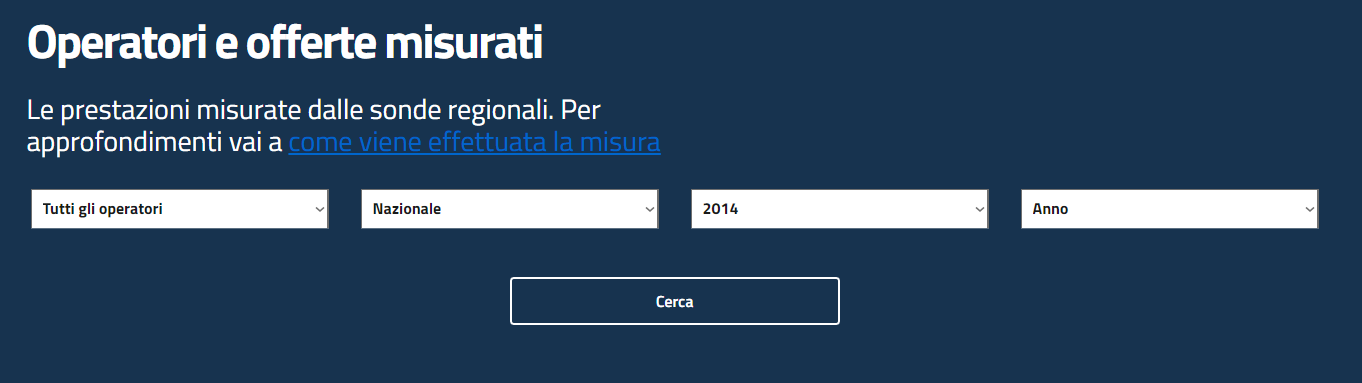

L'operazione per acquisire tutte le misure è mediamente di 10 minuti.

In [5]:
dataset_speed_all = pd.DataFrame()
regione = pd.DataFrame()
start =  time.perf_counter()

for region in range(1,21):
    for anno in anni:
        annualita = pd.DataFrame()
        sem_1 = pd.DataFrame()
        sem_2 = pd.DataFrame()
        for index, (semestre) in enumerate(semestri):
            for page in range(1,10):
                try:
                    if index==0:
                        sem_1 = pd.concat([sem_1,getDataset(session, middletoken, anno, page, region, semestre)],ignore_index=True) 
                    else:
                        sem_2 = pd.concat([sem_2,getDataset(session, middletoken, anno, page, region, semestre)],ignore_index=True)
                except Exception as error:
                    print(error)
        annualita = pd.concat([sem_1,sem_2], ignore_index=True)
        annualita["Anno"] = anno
        regione = pd.concat([regione,annualita], ignore_index=True)   
dataset_speed_all = pd.concat([dataset_speed_all,regione], ignore_index=True)
print(f'Eleapsed time: {time.perf_counter()-start:0.4f} seconds')

Eleapsed time: 579.1580 seconds


In [6]:
dataset_speed_all

,Operatore,Profilo,Velocità (down/up),Territorio,Periodo,Tipo,Media,Dev. Std.,Min,Max,TP%,Misure,Anno
0,BritishTelecom,"BTADSL7Mega,VipPremium,VipDuet,VipAssolo","\n7,0Mbps832.0kbps\n",Piemonte,\nGen2014Giu2014\n,Download,"6,1Mbps","34,3","6,0Mbps","6,1Mbps",,40340,2014
1,BritishTelecom,"BTADSL7Mega,VipPremium,VipDuet,VipAssolo","\n7,0Mbps832.0kbps\n",Piemonte,\nGen2014Giu2014\n,Ping,15ms,"2,2",,\n16ms\n,0%,20170,2014
2,BritishTelecom,"BTADSL7Mega,VipPremium,VipDuet,VipAssolo","\n7,0Mbps832.0kbps\n",Piemonte,\nGen2014Giu2014\n,Upload,700.0kbps,"17,2",635.0kbps,705.0kbps,,40327,2014
3,BritishTelecom,"VipClub7Mega,VipSmart7Mega,VipDuet,VipAssolo","\n7,0Mbps1,0Mbps\n",Piemonte,\nGen2014Giu2014\n,Download,"5,9Mbps","68,5","5,8Mbps","6,0Mbps",,42096,2014
4,BritishTelecom,"VipClub7Mega,VipSmart7Mega,VipDuet,VipAssolo","\n7,0Mbps1,0Mbps\n",Piemonte,\nGen2014Giu2014\n,Ping,23ms,"1,6",,\n24ms\n,0%,21048,2014
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11659,Wind,"WindHomeADSL,3ADSL,AbsoluteADSL,AllInclusive,A...","\n8,0Mbps512.0kbps\n",Sardegna,\nLug2022Dic2022\n,Ping,"16,0ms","5,4",,"\n22,9ms\n",0%,89860,2022
11660,Wind,"WindHomeADSL,3ADSL,AbsoluteADSL,AllInclusive,A...","\n8,0Mbps512.0kbps\n",Sardegna,\nLug2022Dic2022\n,Upload,481.5kbps,"135,1",483.0kbps,,,8986,2022
11661,Wind,"WindHomeADSL,3ADSL,AbsoluteADSL,AllInclusive,A...","\n10,0Mbps1,0Mbps\n",Sardegna,\nLug2022Dic2022\n,Download,"8,9Mbps","0,8","8,9Mbps",,,3556,2022
11662,Wind,"WindHomeADSL,3ADSL,AbsoluteADSL,AllInclusive,A...","\n10,0Mbps1,0Mbps\n",Sardegna,\nLug2022Dic2022\n,Ping,"14,8ms","0,7",,"\n15,9ms\n",0%,35560,2022


Per sicurezza può essere utile avere un file csv di backup

In [7]:
dataset_speed_all.to_csv('dataset_all_3.csv')

In [8]:
df_download_media = dataset_speed_all[(dataset_speed_all.get("Tipo")=="Download")]

In [9]:
df_download_media_2022=df_download_media[((df_download_media.get("Anno")=="2022"))]
df_download_media_2022

,Operatore,Profilo,Velocità (down/up),Territorio,Periodo,Tipo,Media,Dev. Std.,Min,Max,TP%,Misure,Anno
609,Fastweb,"Superjet,Joy,Jet","\n12,0Mbps1,0Mbps\n",Piemonte,\nGen2022Giu2022\n,Download,"11,0Mbps","0,5","11,0Mbps",,,1392,2022
612,Fastweb,"Superjet,Joy,Jet","\n20,0Mbps1,0Mbps\n",Piemonte,\nGen2022Giu2022\n,Download,"18,2Mbps","826,8","18,3Mbps",,,3909,2022
615,Optima,VitaMiaConsumerFIBRA+FlatvsFissi,"\n100,0Mbps20,0Mbps\n",Piemonte,\nGen2022Giu2022\n,Download,"67,2Mbps","11961,7","39,6Mbps",,,8253,2022
618,TIM,TIMSuperADSL,"\n10,0Mbps1,0Mbps\n",Piemonte,\nGen2022Giu2022\n,Download,"9,8Mbps","107,9","9,8Mbps",,,8207,2022
621,TIM,TIMSuperMega,"\n30,0Mbps3,0Mbps\n",Piemonte,\nGen2022Giu2022\n,Download,"29,5Mbps","1169,6","29,5Mbps",,,8445,2022
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11649,TIM,TIMSuperADSL,"\n10,0Mbps1,0Mbps\n",Sardegna,\nLug2022Dic2022\n,Download,"9,8Mbps","616,7","9,8Mbps",,,2635,2022
11652,TIM,TIMSuperMega,"\n30,0Mbps3,0Mbps\n",Sardegna,\nLug2022Dic2022\n,Download,"29,6Mbps","3,1","29,6Mbps",,,8127,2022
11655,Tiscali,None,"\n100,0Mbps20,0Mbps\n",Sardegna,\nLug2022Dic2022\n,Download,"66,1Mbps","3168,9","64,4Mbps",,,7200,2022
11658,Wind,"WindHomeADSL,3ADSL,AbsoluteADSL,AllInclusive,A...","\n8,0Mbps512.0kbps\n",Sardegna,\nLug2022Dic2022\n,Download,"6,9Mbps","333,8","6,9Mbps",,,8986,2022


In [10]:
def split_string(input_string, chunk_size):
    return [input_string[i:i+chunk_size] for i in range(0, len(input_string), chunk_size)]

In [11]:
def split_string2(string : str):
    index = string.find("bps") 
    return [string[0:index+3],string[index+3:len(string)]]

In [12]:
df_download_media_2022["Periodo"]=df_download_media_2022["Periodo"].apply(lambda x: split_string(x.replace("\n",""),7))
df_download_media_2022["Velocità (down/up)"]=df_download_media_2022["Velocità (down/up)"].apply(lambda x: split_string2(x.replace("\n","")))

C:\Users\mkmed\AppData\Local\Temp\ipykernel_16424\2955080741.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_download_media_2022["Periodo"]=df_download_media_2022["Periodo"].apply(lambda x: split_string(x.replace("\n",""),7))
C:\Users\mkmed\AppData\Local\Temp\ipykernel_16424\2955080741.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_download_media_2022["Velocità (down/up)"]=df_download_media_2022["Velocità (down/up)"].apply(lambda x: split_string2(x.replace("\n","")))


In [13]:
df_download_media_2022

,Operatore,Profilo,Velocità (down/up),Territorio,Periodo,Tipo,Media,Dev. Std.,Min,Max,TP%,Misure,Anno
609,Fastweb,"Superjet,Joy,Jet","[12,0Mbps, 1,0Mbps]",Piemonte,"[Gen2022, Giu2022]",Download,"11,0Mbps","0,5","11,0Mbps",,,1392,2022
612,Fastweb,"Superjet,Joy,Jet","[20,0Mbps, 1,0Mbps]",Piemonte,"[Gen2022, Giu2022]",Download,"18,2Mbps","826,8","18,3Mbps",,,3909,2022
615,Optima,VitaMiaConsumerFIBRA+FlatvsFissi,"[100,0Mbps, 20,0Mbps]",Piemonte,"[Gen2022, Giu2022]",Download,"67,2Mbps","11961,7","39,6Mbps",,,8253,2022
618,TIM,TIMSuperADSL,"[10,0Mbps, 1,0Mbps]",Piemonte,"[Gen2022, Giu2022]",Download,"9,8Mbps","107,9","9,8Mbps",,,8207,2022
621,TIM,TIMSuperMega,"[30,0Mbps, 3,0Mbps]",Piemonte,"[Gen2022, Giu2022]",Download,"29,5Mbps","1169,6","29,5Mbps",,,8445,2022
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11649,TIM,TIMSuperADSL,"[10,0Mbps, 1,0Mbps]",Sardegna,"[Lug2022, Dic2022]",Download,"9,8Mbps","616,7","9,8Mbps",,,2635,2022
11652,TIM,TIMSuperMega,"[30,0Mbps, 3,0Mbps]",Sardegna,"[Lug2022, Dic2022]",Download,"29,6Mbps","3,1","29,6Mbps",,,8127,2022
11655,Tiscali,None,"[100,0Mbps, 20,0Mbps]",Sardegna,"[Lug2022, Dic2022]",Download,"66,1Mbps","3168,9","64,4Mbps",,,7200,2022
11658,Wind,"WindHomeADSL,3ADSL,AbsoluteADSL,AllInclusive,A...","[8,0Mbps, 512.0kbps]",Sardegna,"[Lug2022, Dic2022]",Download,"6,9Mbps","333,8","6,9Mbps",,,8986,2022


In [14]:
min_max = df_download_media_2022[["Operatore","Velocità (down/up)","Min","Territorio","Anno"]]

In [15]:
def extract_numeric(string: str):
    if "kbps" in string:
        print(f'velocità {string}') 
    numeric_values = re.findall(r'-?\d+\.?\d*', string)
    numeric_values = [float(value) for value in numeric_values]
    return numeric_values[0]

In [16]:
def extract_numeric2(string: str):
    if "kbps" in string:
        numeric_values = re.findall(r'-?\d+\.?\d*', string)
        numeric_values = [float(value)/1000 for value in numeric_values]
    else:
        numeric_values = re.findall(r'-?\d+\.?\d*', string)
        numeric_values = [float(value) for value in numeric_values]
    return numeric_values[0]+(numeric_values[len(numeric_values)-1]/10)

In [17]:
min_max["Velocità (down/up)"] = min_max["Velocità (down/up)"].apply(lambda x: extract_numeric(x[0]))
min_max["Min"] = min_max["Min"].apply(lambda x: extract_numeric2(x))
min_max

C:\Users\mkmed\AppData\Local\Temp\ipykernel_16424\2758054312.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  min_max["Velocità (down/up)"] = min_max["Velocità (down/up)"].apply(lambda x: extract_numeric(x[0]))
C:\Users\mkmed\AppData\Local\Temp\ipykernel_16424\2758054312.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  min_max["Min"] = min_max["Min"].apply(lambda x: extract_numeric2(x))


,Operatore,Velocità (down/up),Min,Territorio,Anno
609,Fastweb,12.0,11.0,Piemonte,2022
612,Fastweb,20.0,18.3,Piemonte,2022
615,Optima,100.0,39.6,Piemonte,2022
618,TIM,10.0,9.8,Piemonte,2022
621,TIM,30.0,29.5,Piemonte,2022
...,...,...,...,...,...
11649,TIM,10.0,9.8,Sardegna,2022
11652,TIM,30.0,29.6,Sardegna,2022
11655,Tiscali,100.0,64.4,Sardegna,2022
11658,Wind,8.0,6.9,Sardegna,2022


Text(0.5, 0, 'Velocità')

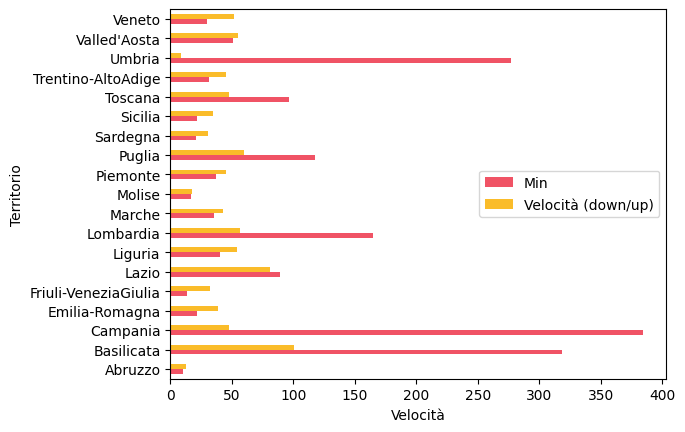

In [112]:
min_max_for_plot = min_max[["Territorio","Min","Velocità (down/up)"]].groupby("Territorio").mean()
min_max_for_plot.plot.barh(legend=True, color=[(240/255,83/255,101/255),(250/255,188/255,42/255)])
plt.xlabel("Velocità")

In [80]:
min_max_for_plot

,Min,Velocità (down/up)
Territorio,,
Abruzzo,10.307692,12.384615
Basilicata,318.775000,100.250000
Campania,403.870741,48.111111
Emilia-Romagna,21.718182,38.409091
Friuli-VeneziaGiulia,13.333333,32.619048
Lazio,89.434211,80.868421
Liguria,40.284000,53.920000
Lombardia,164.742308,56.923077
Marche,35.678571,42.892857


In [ ]:
import geopandas